In [1]:
# Import Core library
import sys
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, nltk
import emoji
from pprint import pprint
from cleantext import clean
from top2vec import Top2Vec

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
# Import Dataset
df = pd.read_excel('Community306_raw.xlsx')

In [ ]:
df.head()

In [4]:
df['text'].head()

0    @HHere4trump @sbacon0410 #stopthesteal #stopth...
1    @RudyGiuliani @CaliConserv1 #StoptheSteal #Sto...
2    #StoptheSteal #StoptheSteal #StoptheSteal #Sto...
3    #StoptheSteal #StoptheSteal #StoptheSteal #Sto...
4    @realDonaldTrump @4Libertyinlaw #StoptheSteal ...
Name: text, dtype: object

In [5]:
df['create_year'] = pd.to_datetime(df.created_at, format='%d/%m/%Y', errors='coerce')
df['year'] = pd.to_datetime(df.created_at).dt.strftime('%Y')
df['month'] = pd.to_datetime(df.created_at).dt.strftime('%m')

In [6]:
start_date = "15/12/2020"
end_date = "31/01/2021"
after_start_date = df['create_year'] > start_date
before_end_date = df['create_year'] < end_date
between_two_dates = after_start_date & before_end_date

stream_one = df.loc[between_two_dates]

In [ ]:
stream_one.head()

In [8]:
# Convert to list
data = stream_one['text'].values.tolist()

# Make characters lowercase
data = [word.lower() for word in data]

In [ ]:
data[:20]

In [10]:
def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')

def get_hashtags_pattern():
    return re.compile(r'#\w*')

def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')

def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')

def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')

def get_mentions_pattern():
    return re.compile(r'@\w*')

def process_text(word):
  word=re.sub(pattern=get_url_patern(), repl='', string=word)
  word=re.sub(pattern=get_mentions_pattern(), repl='', string=word)
  word=re.sub(pattern=get_hashtags_pattern(), repl='', string=word)
  word=re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=word)
  word=re.sub(pattern=get_single_letter_words_pattern(), repl='', string=word)
  word=re.sub(pattern=get_blank_spaces_pattern(), repl=' ', string=word)
  word=re.sub('\s+', ' ', word)
  word=re.sub("\'", "", word)
  word=re.sub(r'http\S+', '', word)  # remove http links
  word=re.sub(r'bit.ly/\S+', '', word)  # rempve bitly links
  word=word.strip('[link]')  # remove [links]
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', word)  # remove retweet
  word=re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', word)  # remove tweeted at
  word=clean(word, no_emoji=True)
  word =re.sub(r'\d+', '', word)
  word = word.strip()
  return word

In [11]:
data = [process_text(word) for word in data]

In [12]:
model = Top2Vec(data)

2022-03-07 20:12:29,778 - top2vec - INFO - Pre-processing documents for training
2022-03-07 20:12:32,215 - top2vec - INFO - Creating joint document/word embedding
2022-03-07 20:14:28,046 - top2vec - INFO - Creating lower dimension embedding of documents
2022-03-07 20:15:30,514 - top2vec - INFO - Finding dense areas of documents
2022-03-07 20:15:35,974 - top2vec - INFO - Finding topics


In [13]:
model.get_num_topics()

709

In [14]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [15]:
model.topic_words[0]

array(['legitimate', 'accept', 'cc', 'counted', 'stolen', 'overflowing',
       'being', 'right', 'never', 'webs', 'stand', 'votes', 'elects',
       'exempt', 'agreed', 'we', 'president', 'donations', 'our', 'will',
       'election', 'solicit', 'compromise', 'nonprofit', 'have',
       'demanding', 'with', 'paper', 'amy', 'shall', 'kremer',
       'relentless', 'sleeping', 'crece', 'tie', 'surrender', 'website',
       'open', 'ec', 'absolutely', 'ot', 'vp', 'personally', 'pence',
       'ceificates', 'tokyo', 'illegitimate', 'hashtag', 'texan',
       'donate'], dtype='<U15')

In [16]:
topic_dist = pd.DataFrame()

for topic_num in topic_nums:
    topic_dist = topic_dist.append(pd.Series([topic_num, model.topic_words[topic_num]]), ignore_index=True)
    
topic_dist.columns = ['Topic_Number', 'Topic_Words']

In [17]:
topic_dist.head(10)

Topic_Number                                        Topic_Words
0           0.0  [legitimate, accept, cc, counted, stolen, over...
1           1.0  [kicked, flight, wearing, joke, mask, suppoer,...
2           2.0  [location, cap, minutes, inciter, tweeted, thr...
3           3.0  [plaza, pre, coalition, freedom, live, toronto...
4           4.0  [matte, refused, idiot, lives, mayor, calling,...
5           5.0  [supp, vet, combat, asked, event, speak, pro, ...
6           6.0  [exercise, solution, judicial, thei, legislatu...
7           7.0  [conference, coalition, press, rsbn, plaza, wa...
8           8.0  [paged, diego, san, airpo, fullest, maps, some...
9           9.0  [overflowing, maga, millions, here, elects, st...

In [18]:
topics_10 = topic_nums[:10]

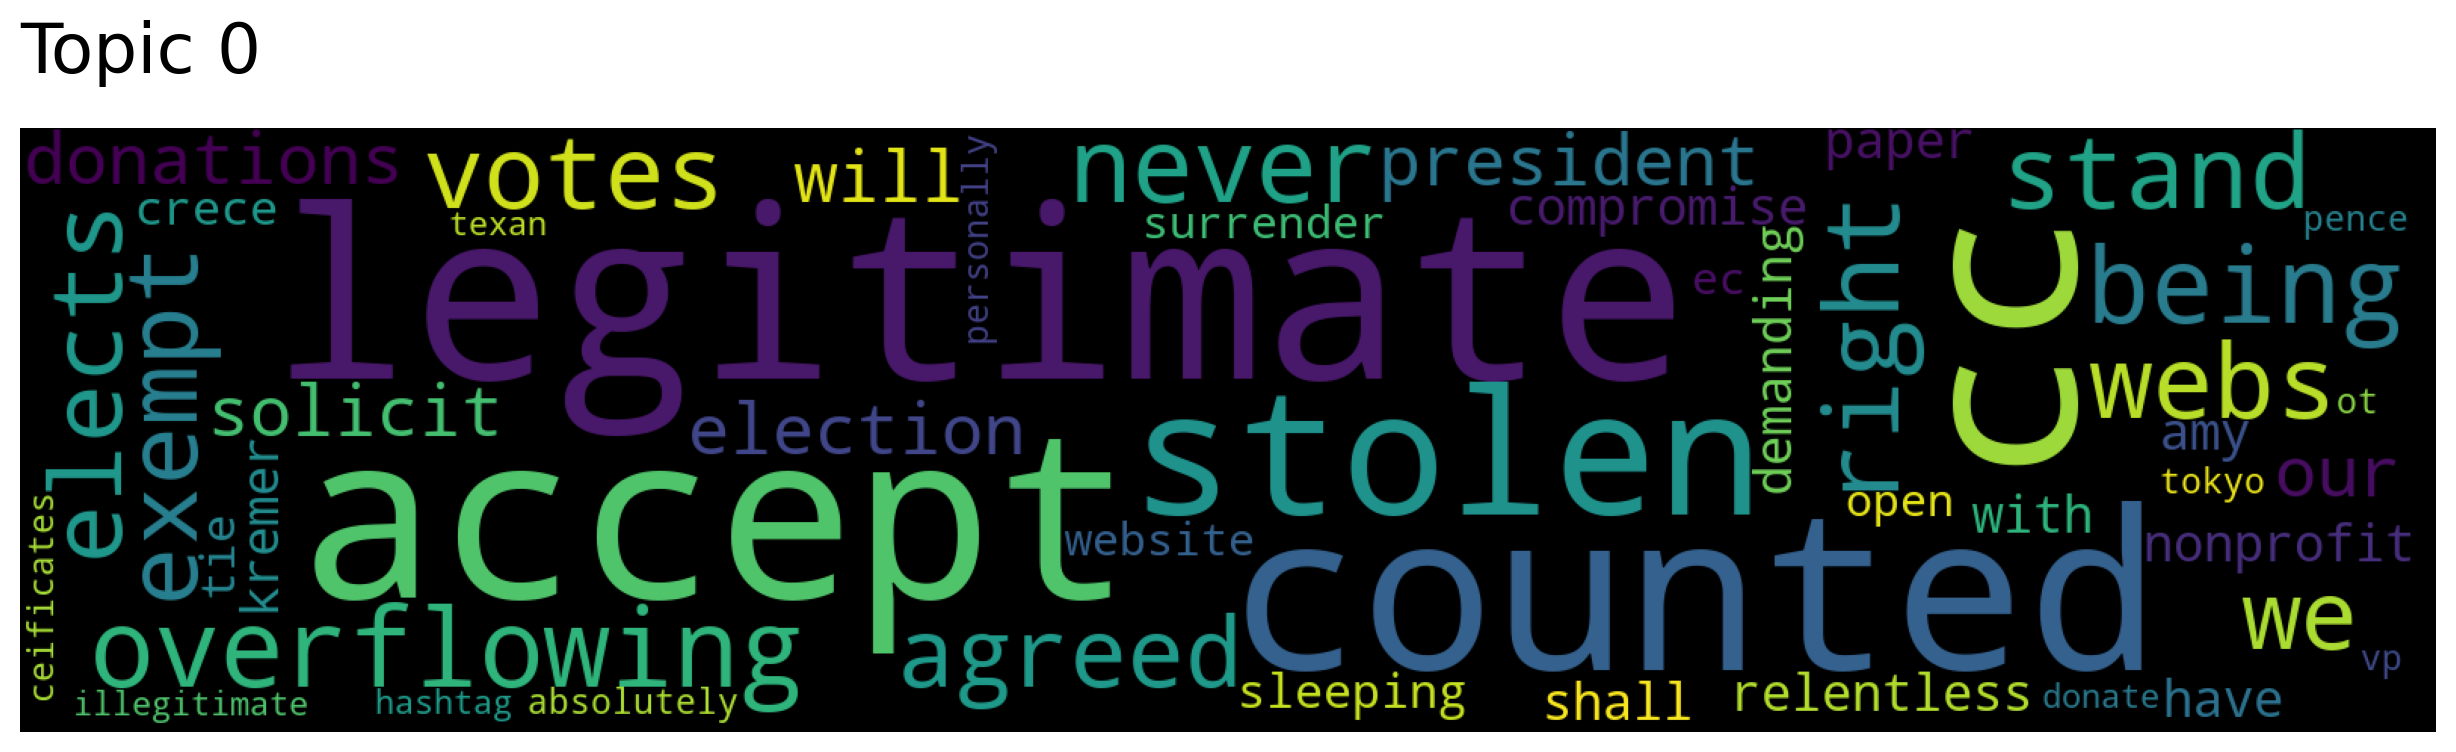

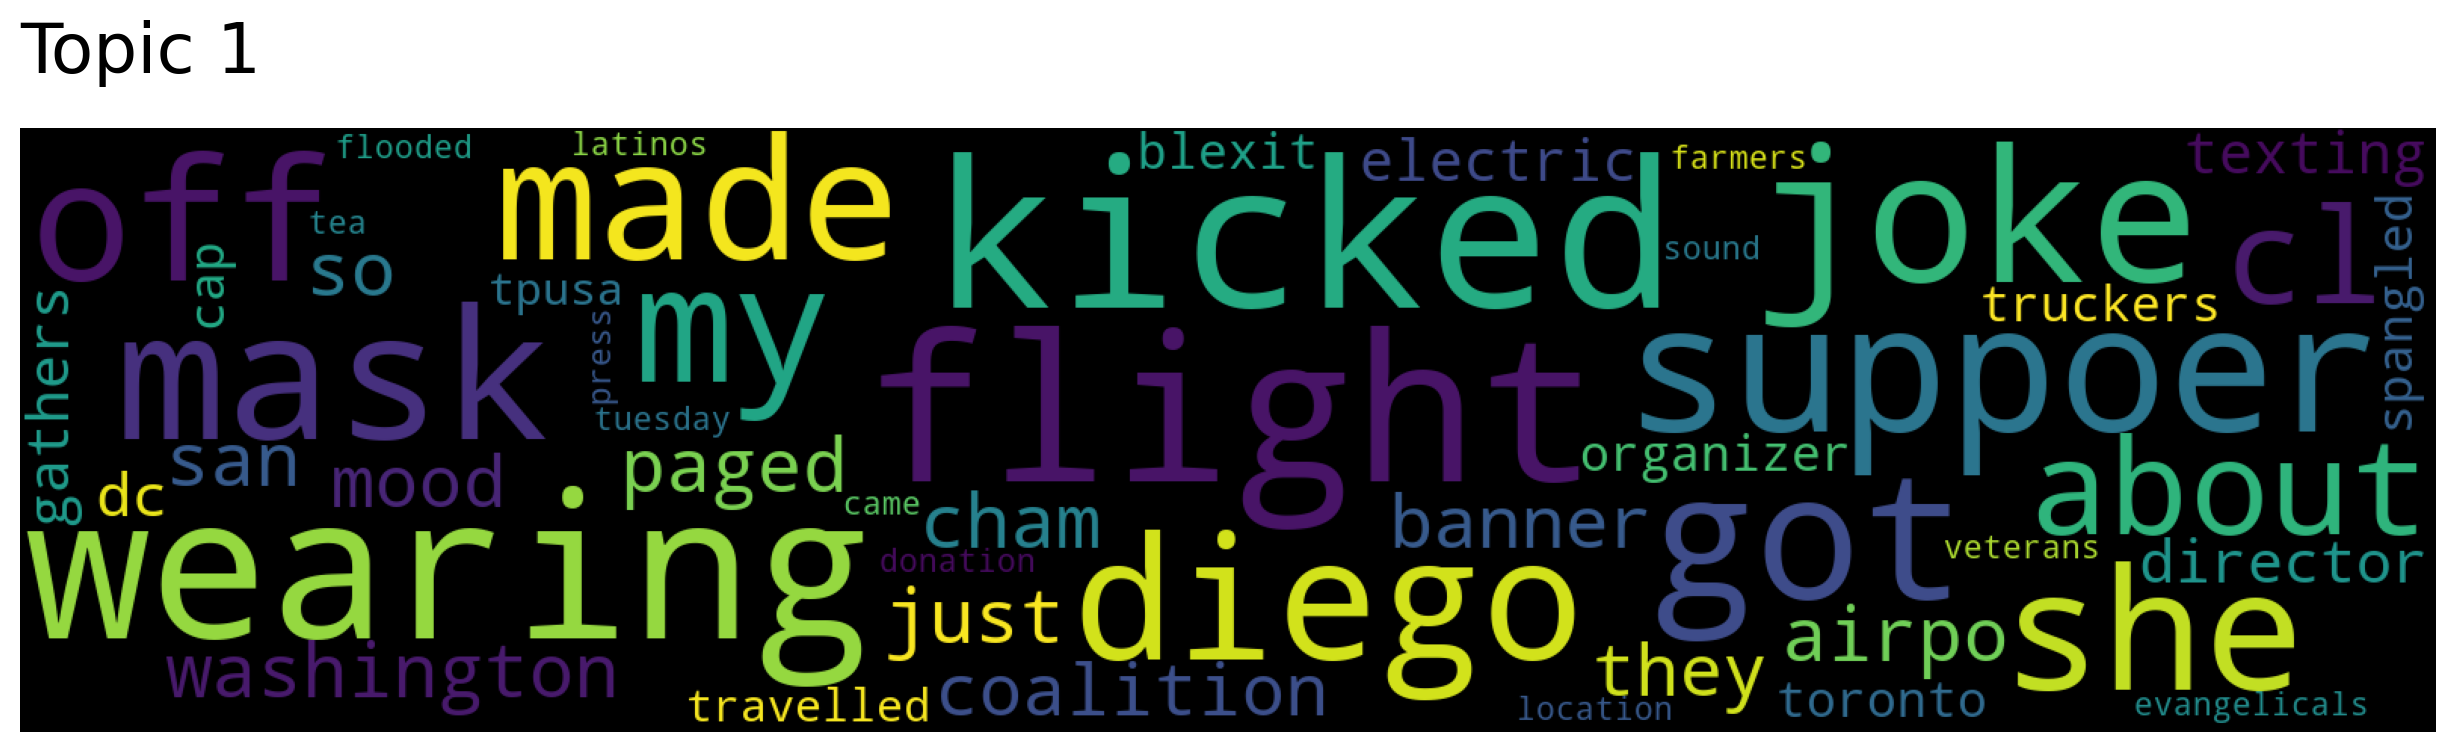

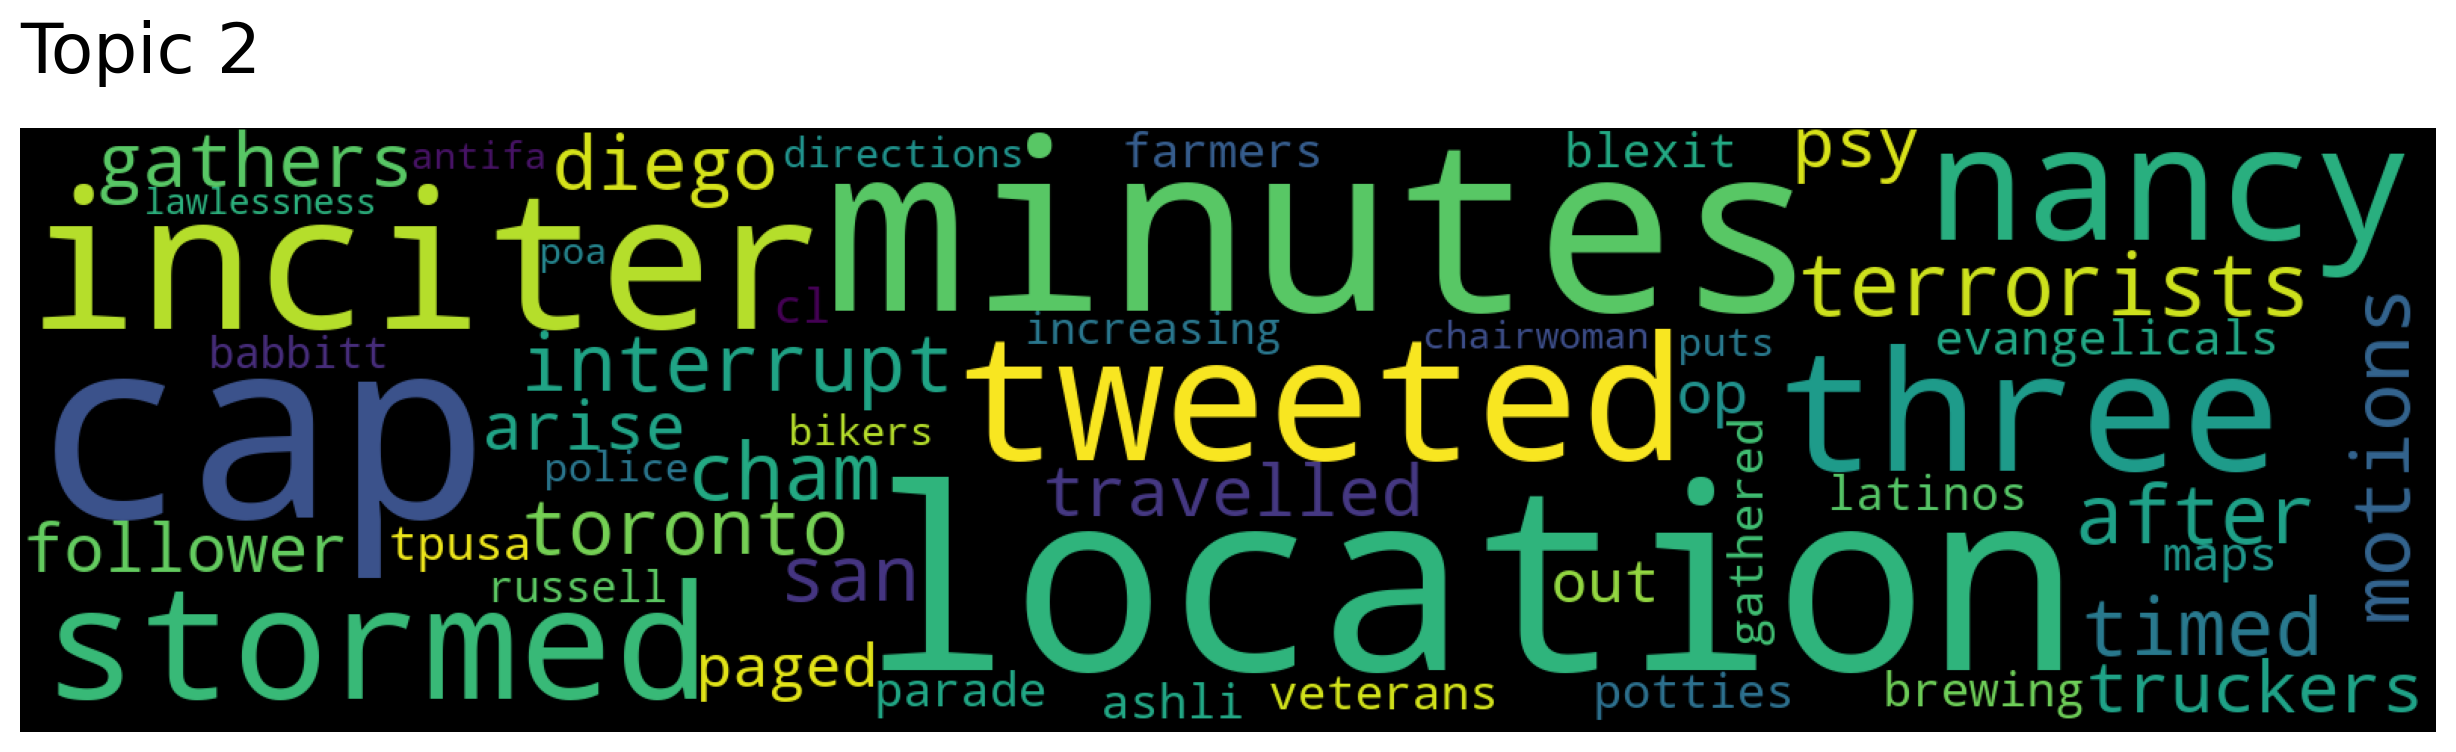

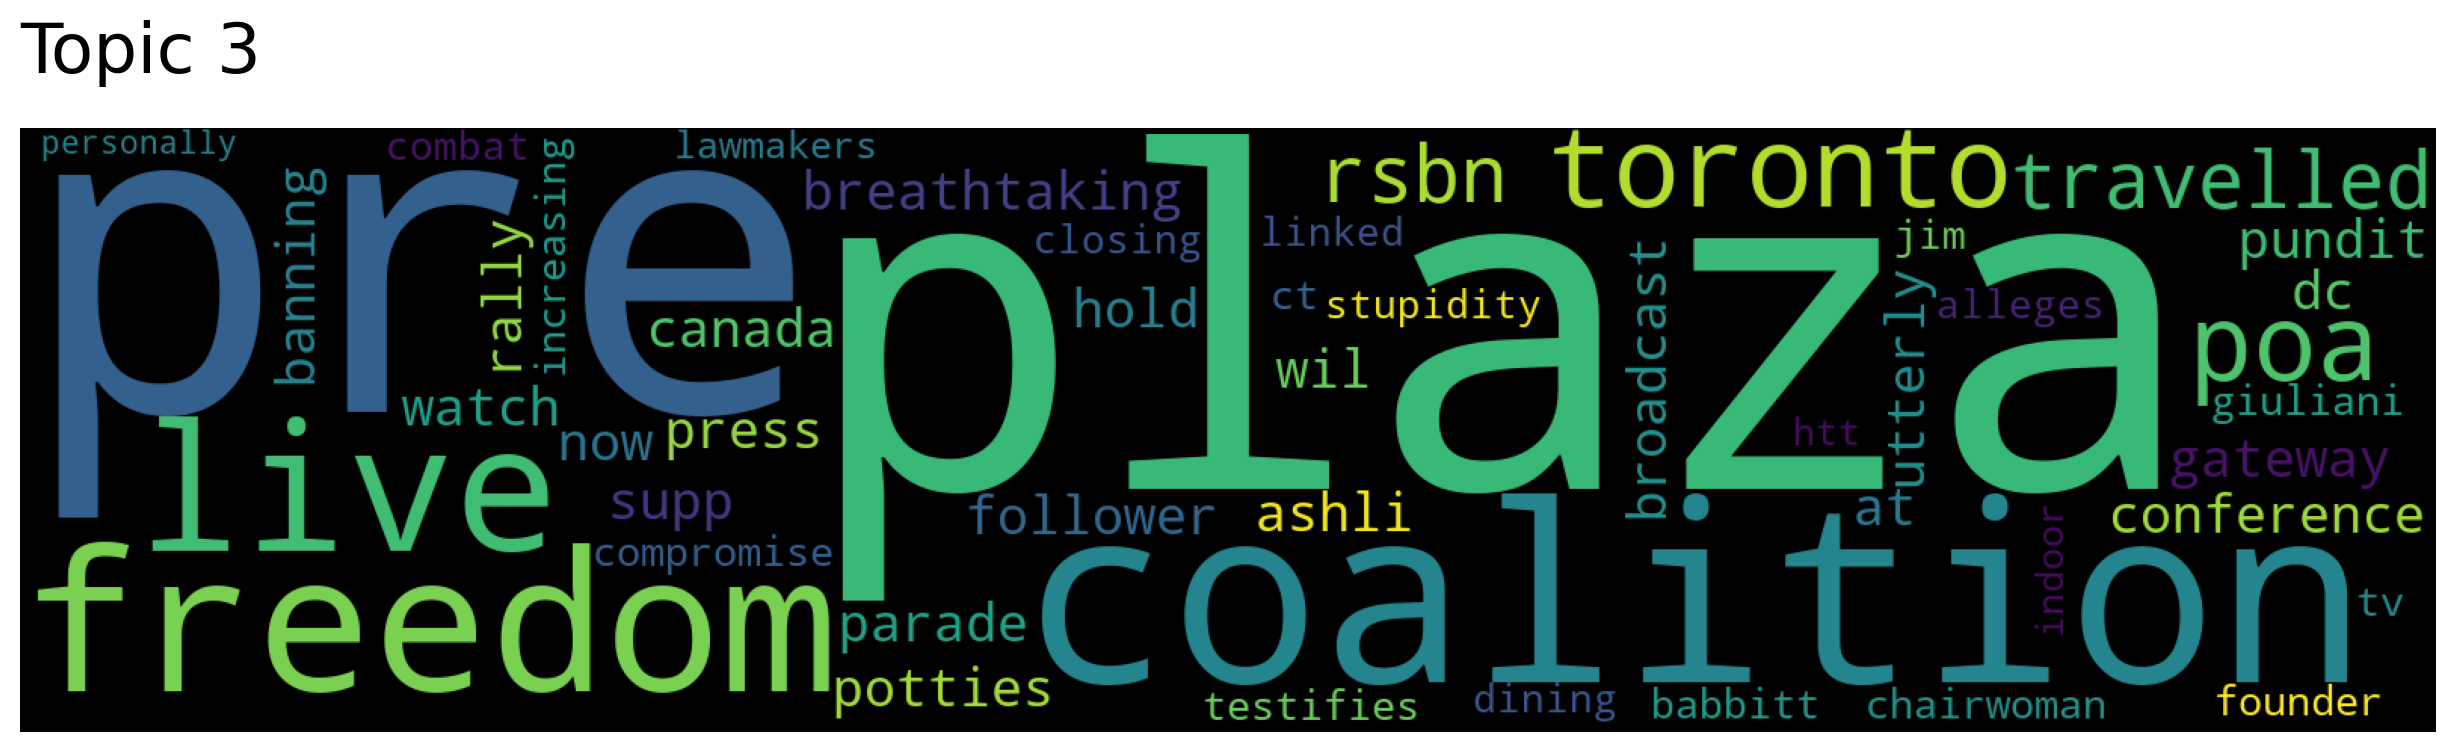

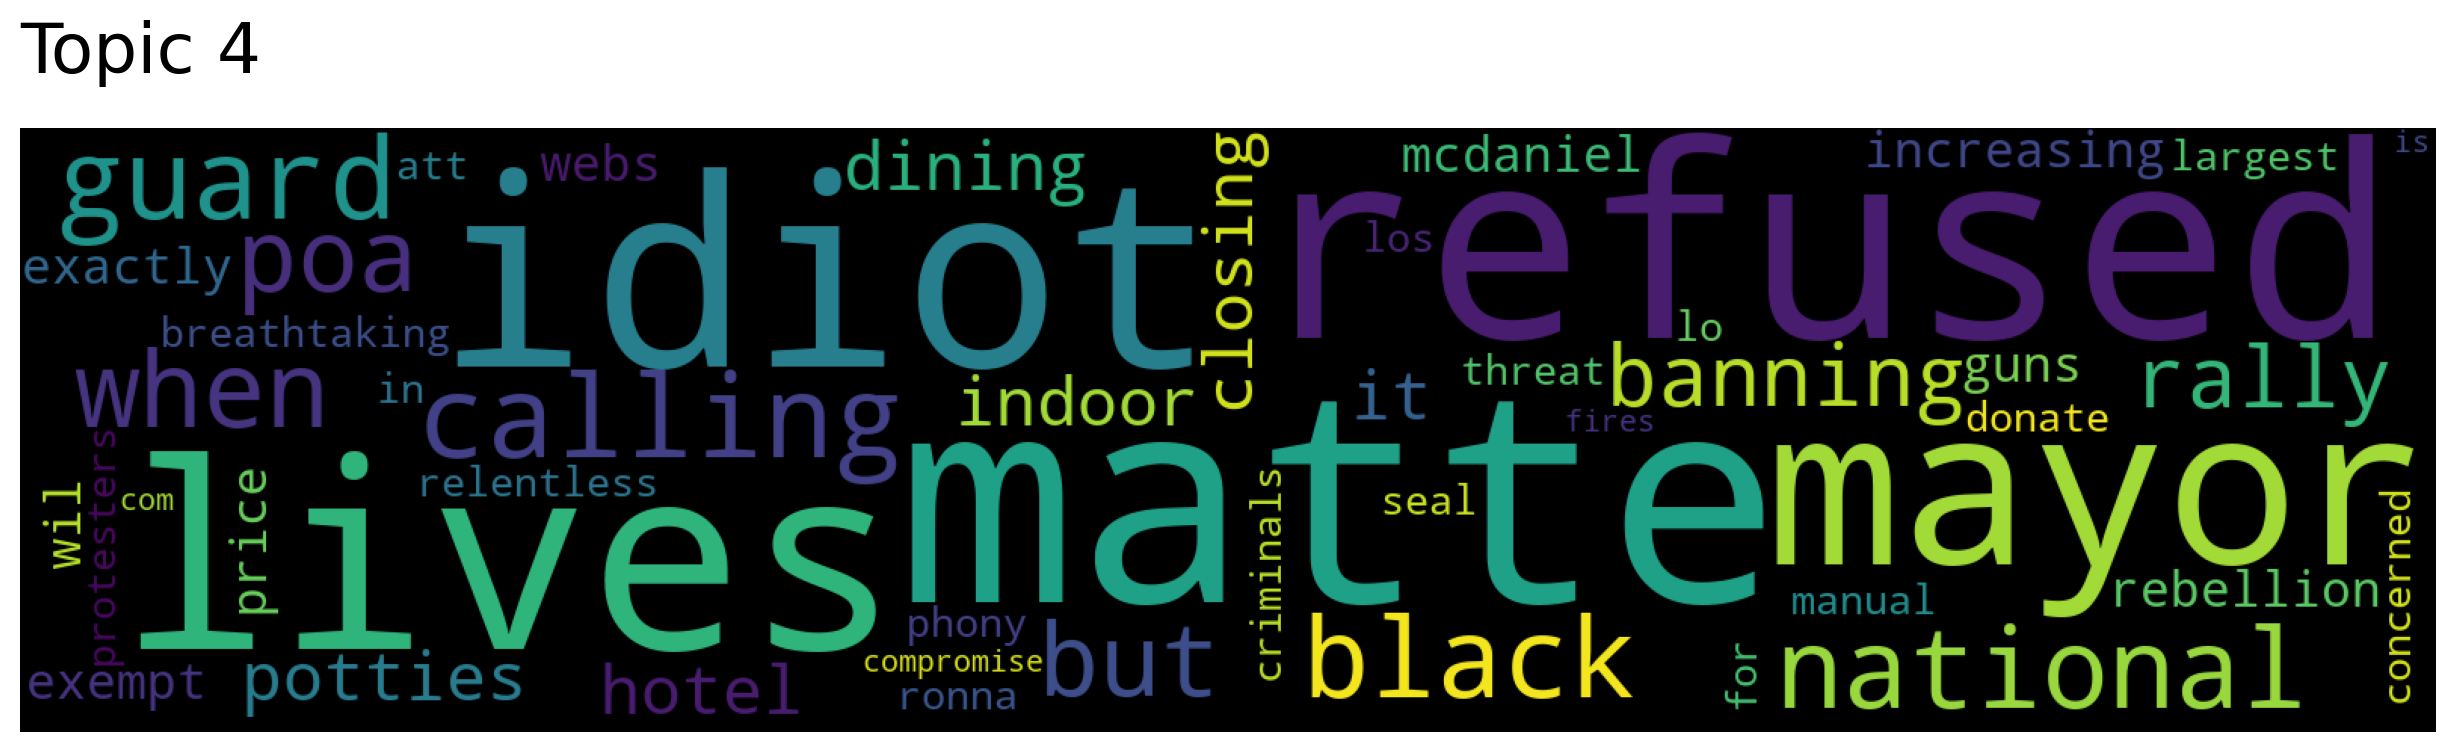

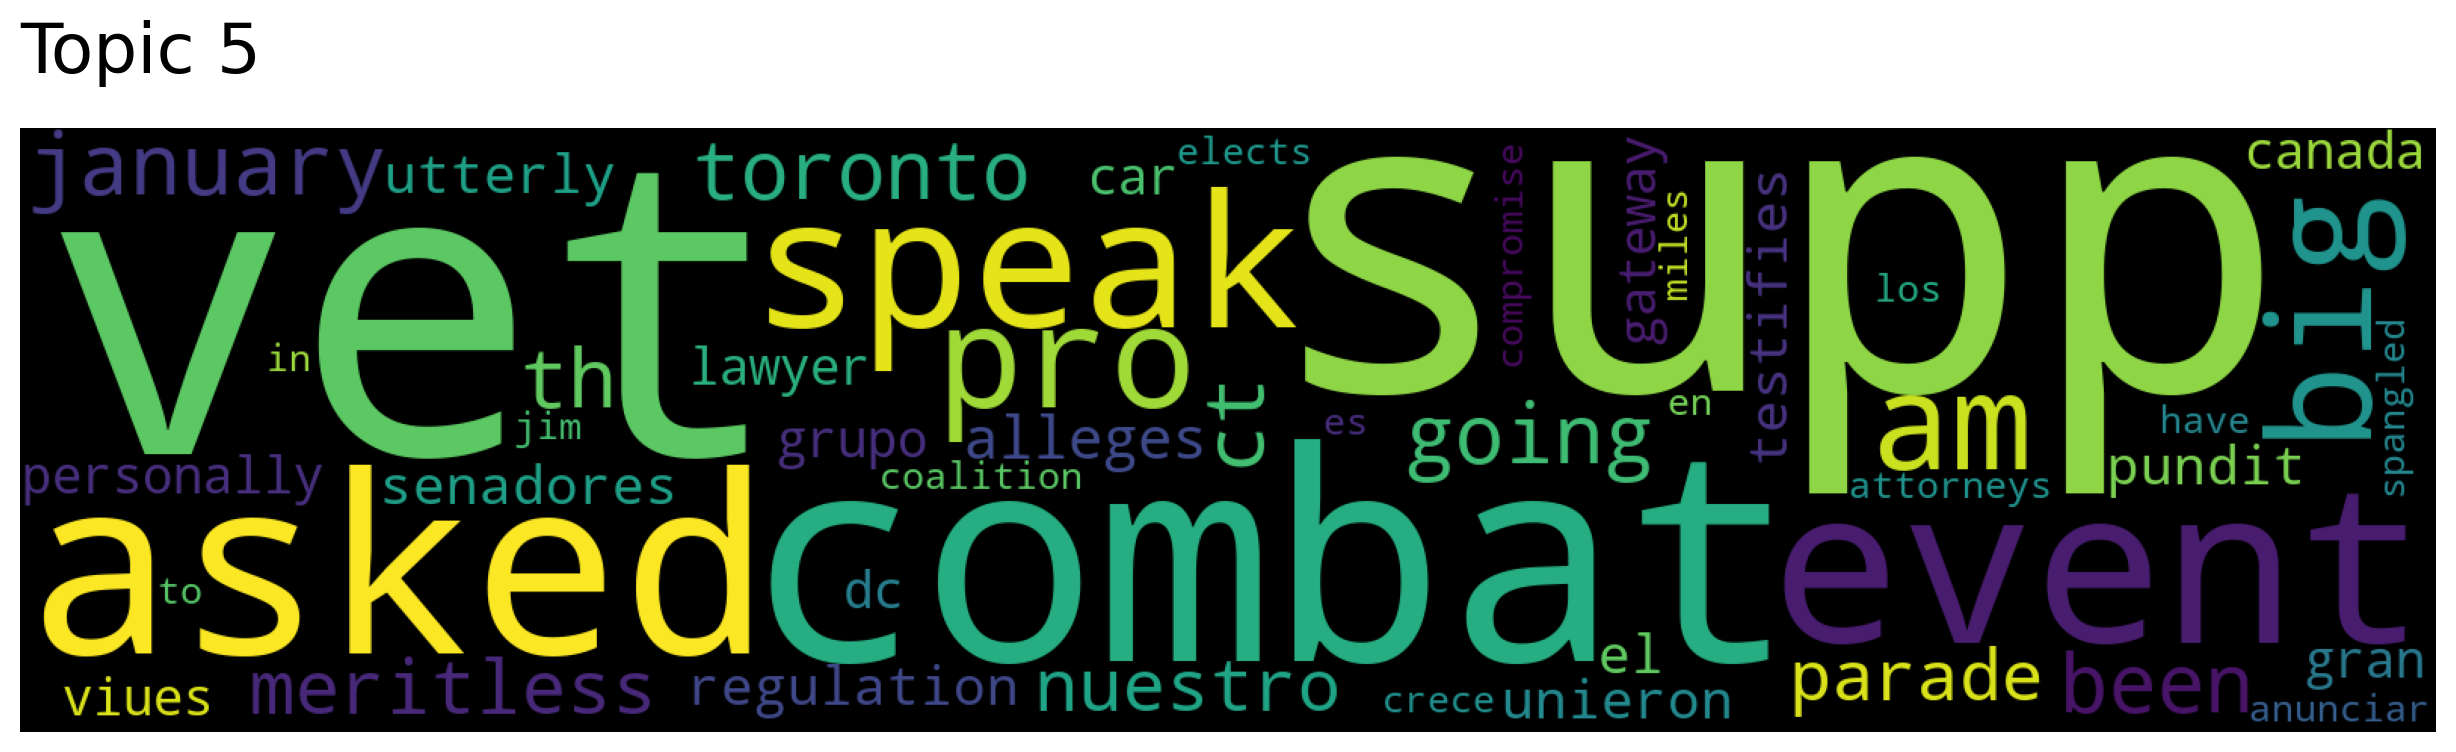

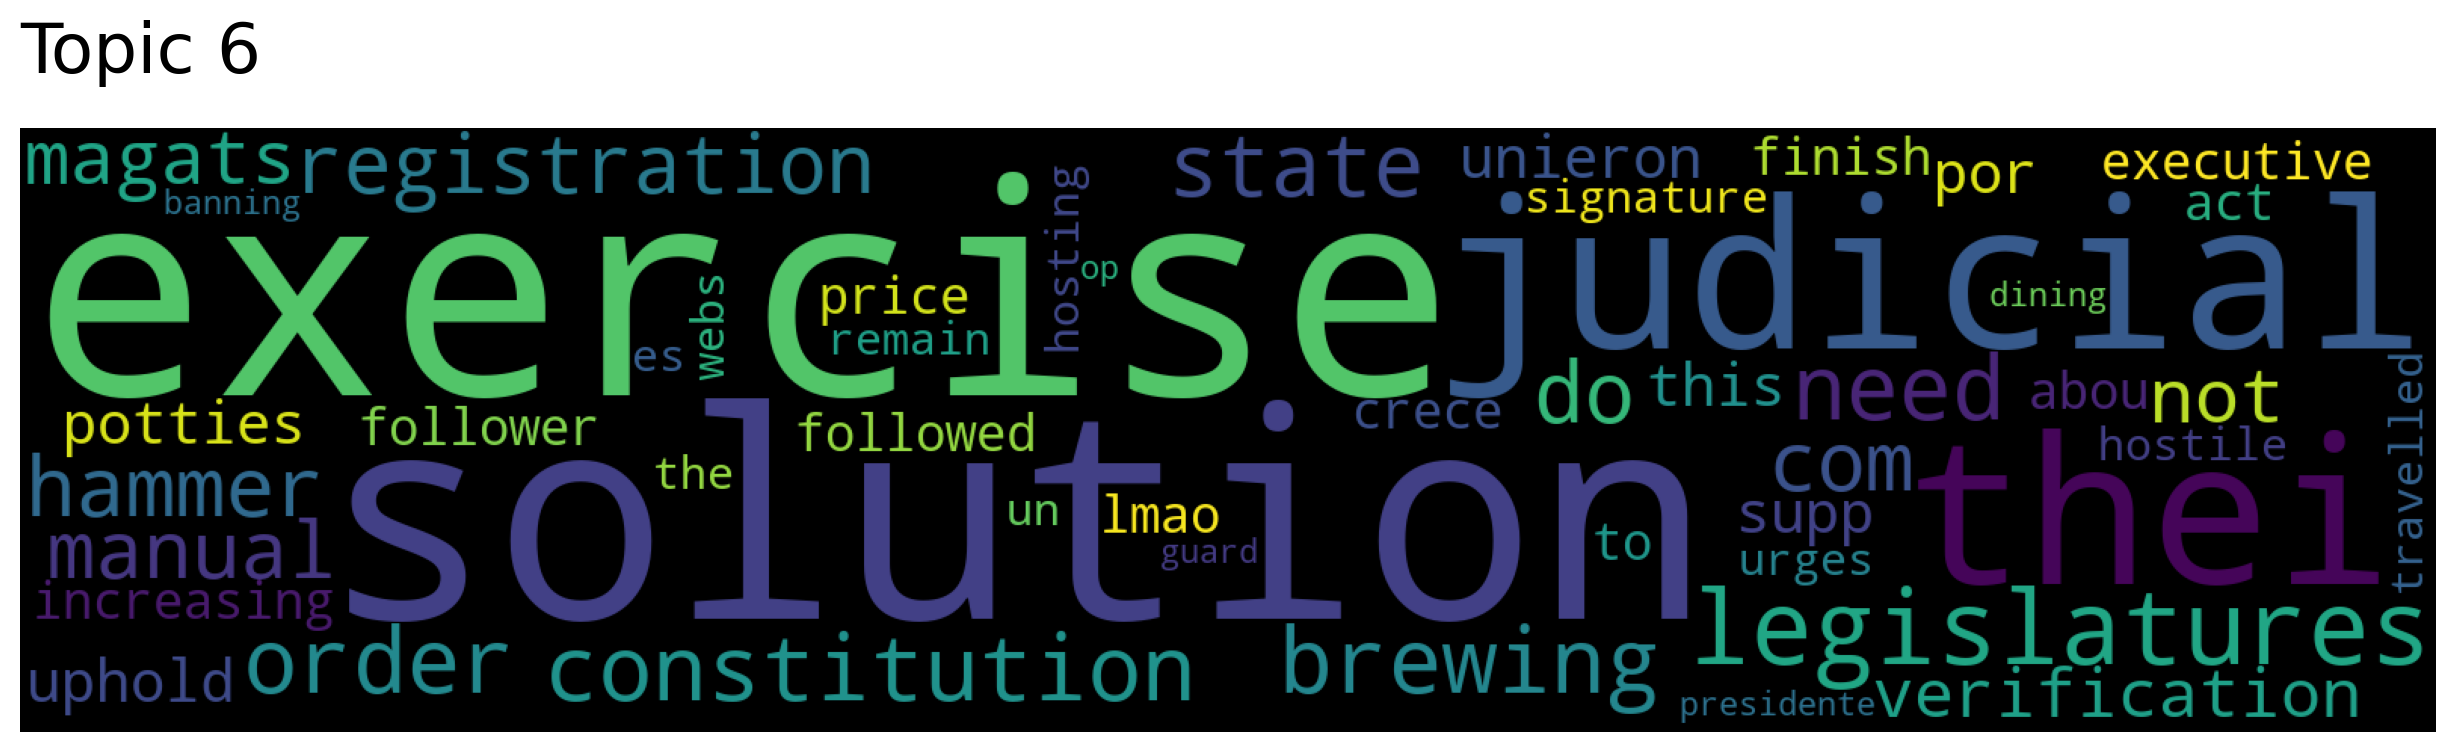

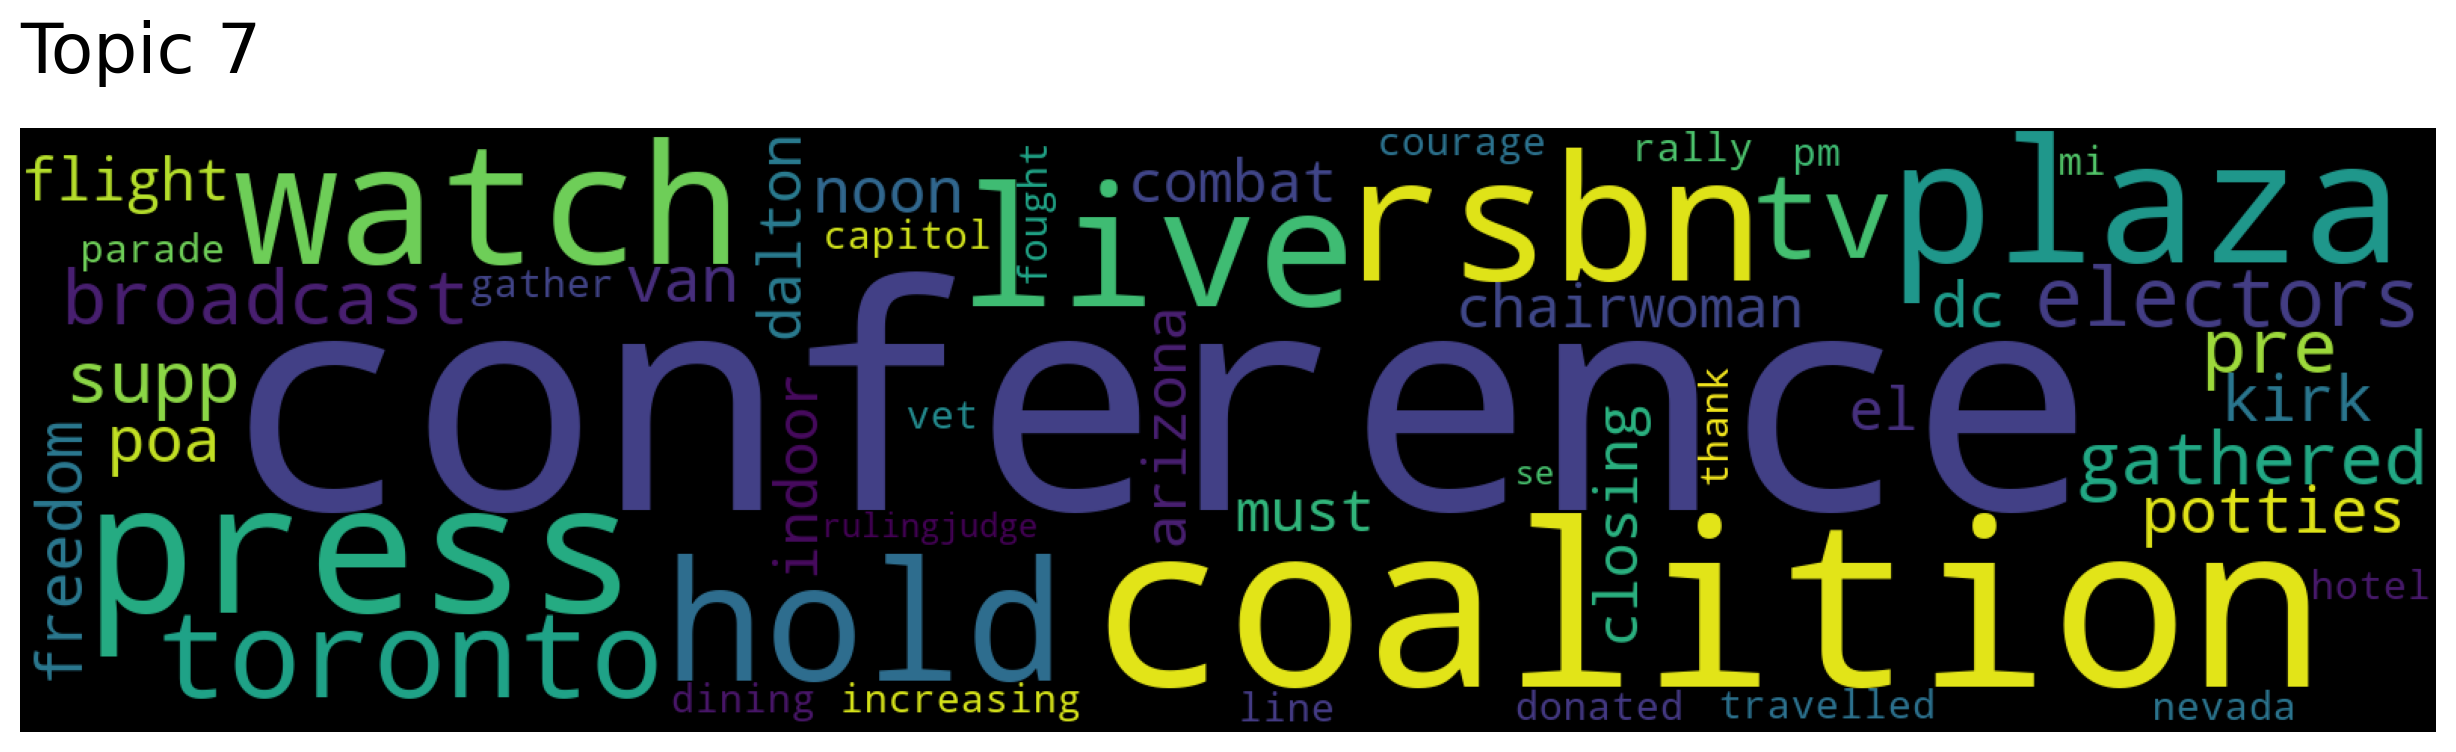

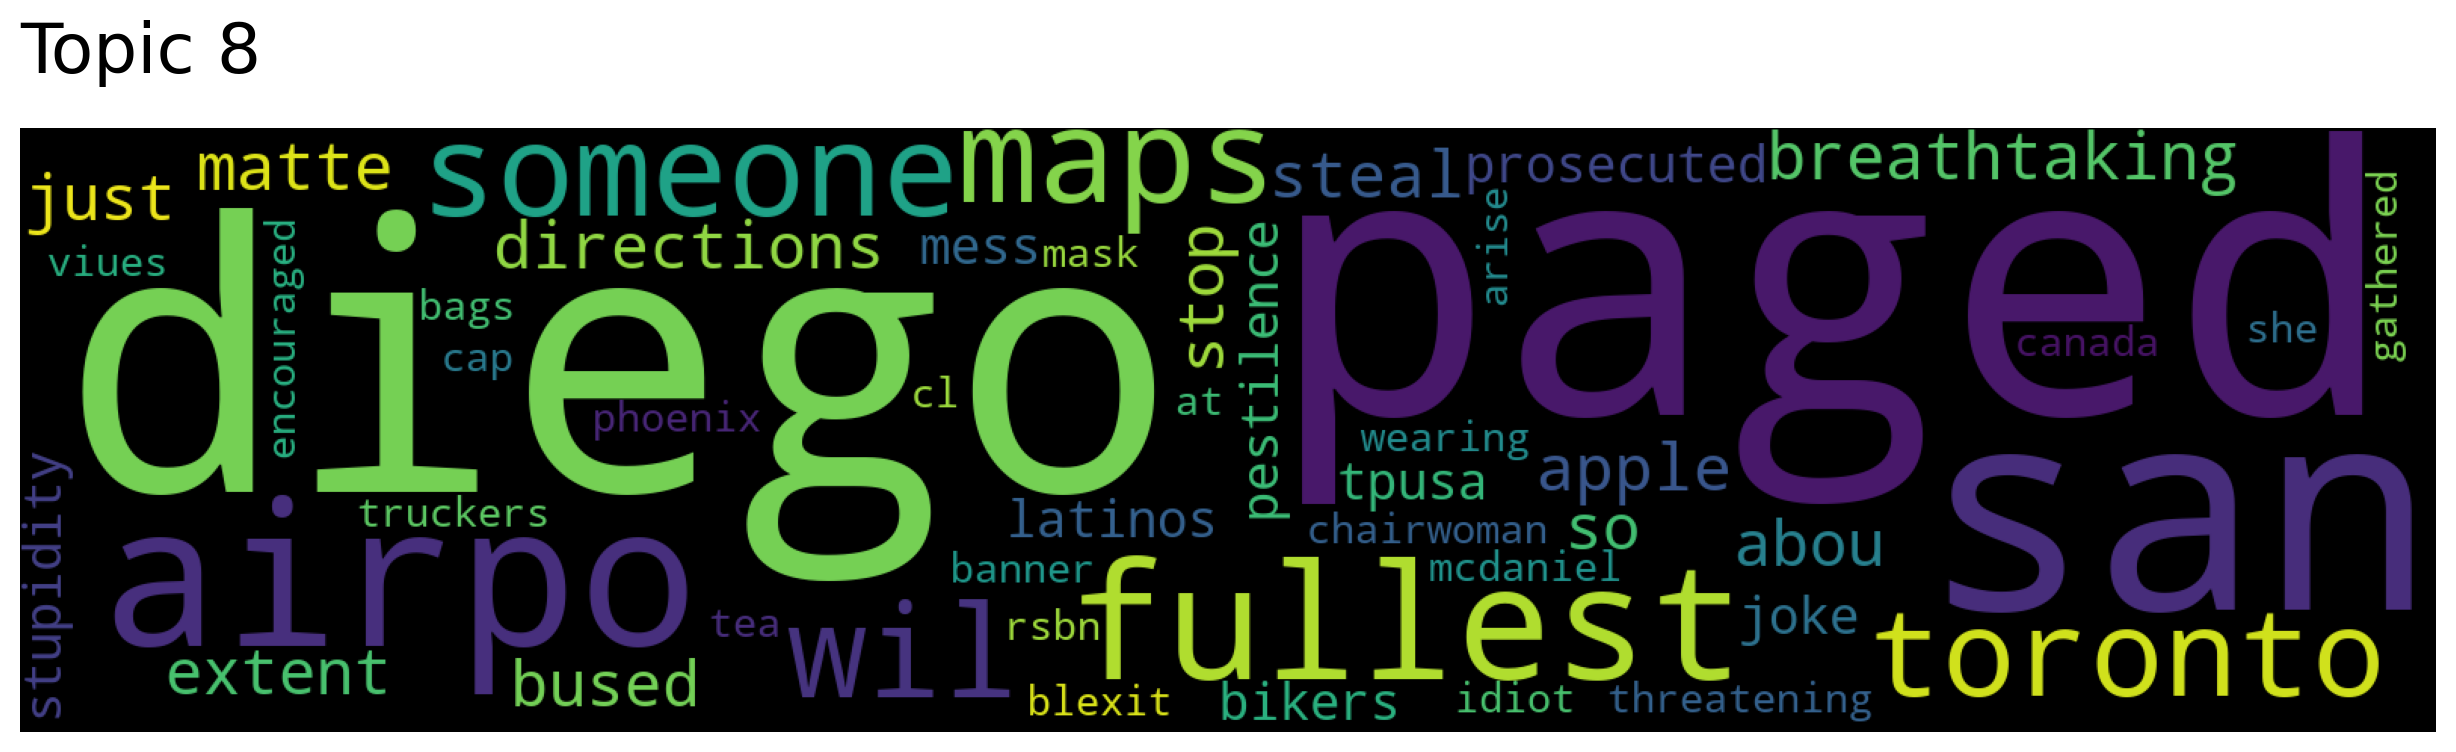

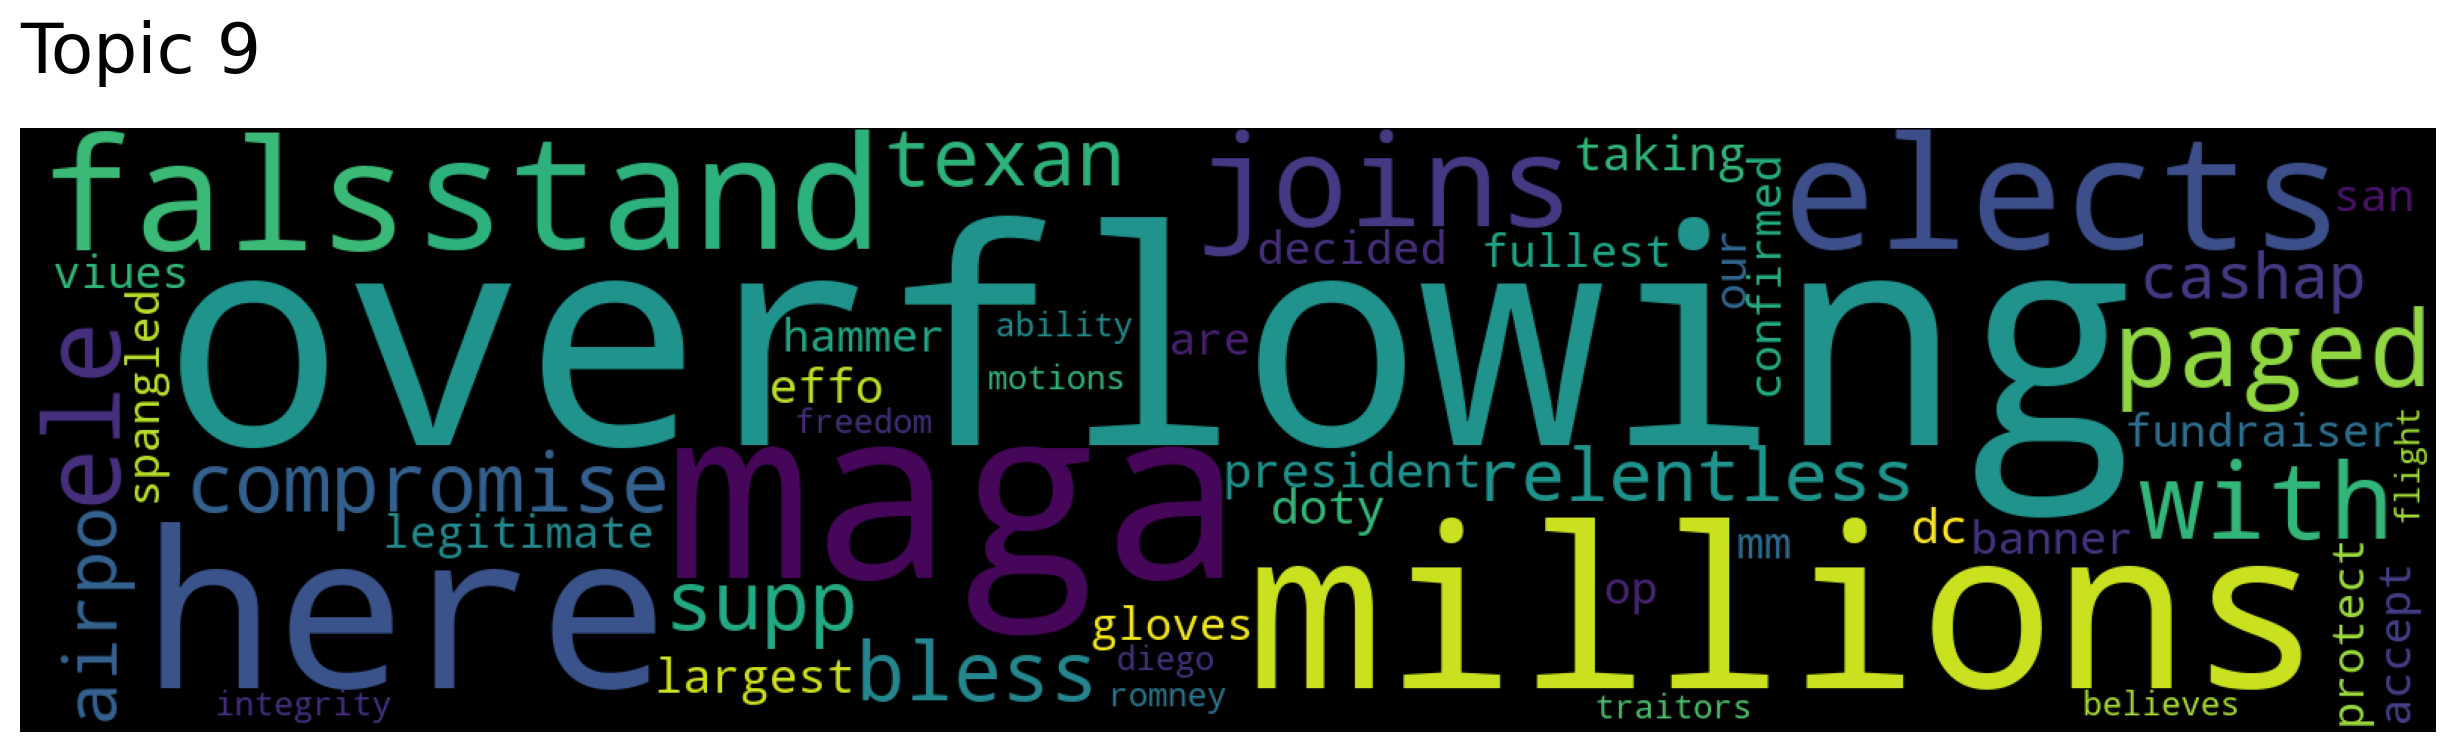

In [19]:
# topic_words, word_scores, topic_scores, topic_numbers = model.
for topic in topics_10:
    model.generate_topic_wordcloud(topic)